<a href="https://colab.research.google.com/github/hyang0129/project/blob/main/IMGNETPROTOTYPE.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# SETUP

In [ ]:
!pip install -q einops

In [ ]:
import math, re, os
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import tensorflow as tf
import tensorflow.keras.layers as L
from sklearn import metrics
from sklearn.model_selection import train_test_split, KFold
import cv2
import tensorflow_addons as tfa
import PIL
import tensorflow.keras.backend as K
from tqdm.notebook import tqdm
import tensorflow_datasets as tfds
from einops import rearrange


In [ ]:
import os
assert 'COLAB_TPU_ADDR' in os.environ, 'ERROR: Not connected to a TPU runtime; please see the first cell in this notebook for instructions!'
TPU_ADDRESS = 'grpc://' + os.environ['COLAB_TPU_ADDR']
print('TPU address is', TPU_ADDRESS)

import tensorflow as tf
# Detect hardware, return appropriate distribution strategy
try:
    # TPU detection. No parameters necessary if TPU_NAME environment variable is
    # set: this is always the case on Kaggle.
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
    print('Running on TPU ', tpu.master())
except ValueError:
    tpu = None

if tpu:
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.experimental.TPUStrategy(tpu)
else:
    # Default distribution strategy in Tensorflow. Works on CPU and single GPU.
    strategy = tf.distribute.get_strategy()

print("REPLICAS: ", strategy.num_replicas_in_sync)


TPU address is grpc://10.38.226.50:8470
Running on TPU  grpc://10.38.226.50:8470
INFO:tensorflow:Initializing the TPU system: grpc://10.38.226.50:8470


INFO:tensorflow:Initializing the TPU system: grpc://10.38.226.50:8470


INFO:tensorflow:Clearing out eager caches


INFO:tensorflow:Clearing out eager caches


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Found TPU system:


INFO:tensorflow:Found TPU system:


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


REPLICAS:  8


# HYPER PARAMETERS

In [ ]:
class P():
    epochs = 50
    net_input_dim = (224, 224, 3) 
    batch_size = 1024
    num_train_img = 1281167
    shuffle_buffer_size = 4096
    mean = [103.939, 116.779, 123.68]
    std = [58.393, 57.12, 57.375]
    num_class = 1000
    initial_learning_rate = 0.05
    minimum_learning_rate = 0.0001
    epoch_num = epochs 
    iterations_per_epoch = num_train_img / batch_size
    steps_per_epoch = iterations_per_epoch
    warm_iterations = iterations_per_epoch
    architecture = 'resnet' # resnet, botnet

# DATASET DEFINITION

## AUGMENTATION

In [ ]:
def augment_image(example):

    image = example['image']


    image = tf.image.resize_with_pad(image, 256,256)
    # IMPLEMENT ZOOM 
    # image = random_size(image)
    image = tf.image.random_crop(image, P.net_input_dim)
    image = tf.image.random_flip_left_right(tf.image.random_flip_up_down(image))

    example['image'] = image 

    return example

def process_image(example):

    image = example['image']
    image = tf.image.resize_with_pad(image, 256,256)
    image = tf.image.central_crop(image, 0.875)
    image = tf.image.resize_with_pad(image, P.net_input_dim[0], P.net_input_dim[1])

    example['image'] = image 

    return example 

def normalize(example): 
    image = example['image']
    image = tf.cast(image, tf.float32)

    image = image - P.mean 
    iamge = image / P.std

    image = image/255.
    example['image'] = image 
    return example 

def compress(example):

    image = example['image']
    image = tf.cast(image, tf.float32)
    image = image/255.
    image = tf.image.resize_with_pad(image, 256,256)
    image = tf.cast(image * 255., tf.uint8)

    example['image'] = tf.io.encode_jpeg(image)
    return example

def decompress(example):
    example['image'] = tf.image.decode_jpeg(example['image'])
    return example

def to_bfloat16(example):
    example['image'] = tf.cast(example['image'], dtype = 'bfloat16')
    return example 
    

## DATASET PREPARATION

In [ ]:

def get_dataset(ds, augment = False, shuffle = P.shuffle_buffer_size, batch = P.batch_size, repeat = False, to_xy =False, cache_big = False, mixed_p = False): 

    if cache_big:
        ds = ds.map(compress, num_parallel_calls = -1)
        ds = ds.cache()
        ds = ds.map(decompress, num_parallel_calls = -1)
        
    ds = ds.repeat() if repeat else ds 
    ds = ds.map(normalize, num_parallel_calls = -1)
    ds = ds.map(augment_image, num_parallel_calls = -1) if augment else ds.map(process_image)
    ds = ds.map(to_bfloat16, num_parallel_calls = -1) if mixed_p else ds 
    ds = ds.shuffle(shuffle) if shuffle else ds 
    ds = ds.map(lambda x : (x['image'], x['label'])) if to_xy else ds 
    ds = ds.batch(batch) if batch else ds 
    ds = ds.prefetch(-1)

    return ds 


    
ds_train, ds_valid = tfds.load(name="imagenet2012", 
                              split=["train", "validation"], 
                              data_dir="gs://kaggledata2/imgnet", 
                              builder_kwargs={"version": "5.0.0"},)



## DATA SAMPLES

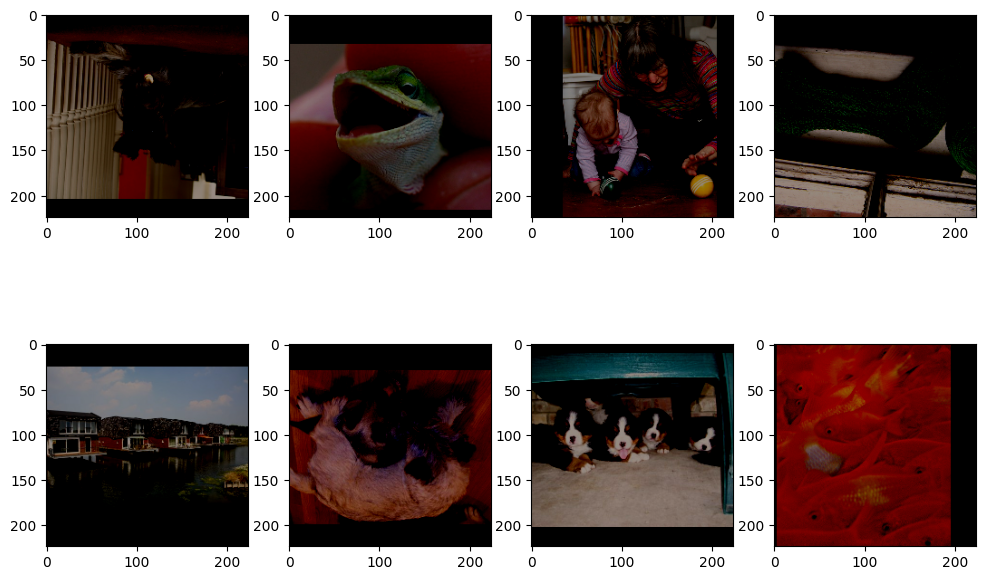

In [ ]:
plt.rcParams['figure.figsize'] = [12, 8]
plt.rcParams['figure.dpi'] = 100

ds  = get_dataset(ds_train, augment = True , shuffle = False, repeat = True)


def draw_grid(imgs, nrow, ncol):

    fig, axs = plt.subplots(nrows=nrow, ncols=ncol)

    for i, ax in enumerate(axs.reshape(-1)):

        img = imgs[i].numpy()
        
        ax.imshow(img)
        

draw_grid(list(ds.take(1))[0]['image'][:8], 2, 4)


# list(ds.take(1))[0][1][:8]



# MODEL DEFINITION

## BASIC RESNET

In [ ]:


def build_resnet():

    model = tf.keras.applications.ResNet50(weights = None, 
                                           input_shape=P.net_input_dim,
                                           include_top = False,
                                           )
    
    out = model.output 
    out = L.GlobalAvgPool2D()(out)
    out = L.Dense(P.num_class, activation='softmax')(out)

    model = tf.keras.Model(inputs = {'image' : model.input}, outputs = {'label' : out})
    return model
    

# build_resnet().summary()

## BOTTLE TRANSFORMER COMMON

In [ ]:
def rel_to_abs(x, b, heads_by_width, l):
    h = heads_by_width
    dtype = tf.keras.mixed_precision.experimental.global_policy().compute_dtype

    x = tf.pad(x, paddings = [[0,0], [0,0], [0,0], [0,1]])
    
    flat_x = rearrange(x, 'b h l c -> b h (l c)')

    flat_x_padded = tf.pad(flat_x, paddings = [[0,0], [0,0], [0,l-1]])

    final_x = tf.reshape(flat_x_padded, (-1, h, l+1, 2*l - 1))
    final_x = final_x[:, :, :l, (l-1):]

    return final_x 

def expand_dim(t, dim, k):
    t = tf.expand_dims(t, axis = dim)
    t = tf.repeat(t, k, axis = dim)
    return t 


def relative_logits_1d(q, rel_k, b, heads, h, w, dim):
    logits = tf.einsum('b h x y d, r d -> b h x y r', q, rel_k)
    logits = rearrange(logits, 'b h x y r -> b (h x) y r')

    logits = rel_to_abs(logits, b, heads * w, w)
    logits = tf.reshape(logits, (-1, heads, h, w, w))
    logits = expand_dim(logits, dim = 3, k = h)
    
    return logits

def to_compute_dtype(tensor):
    return tf.cast(tensor, tf.keras.mixed_precision.global_policy().compute_dtype)

class RelPosEmb(tf.keras.layers.Layer):
    def __init__(self, dimensions_per_head, real_input_shape, *args, **kwargs): 
        super().__init__(*args, **kwargs)
        self.dimensions_per_head = dimensions_per_head
        self.real_input_shape = real_input_shape

 
    def build(self, input_shape): 

        b, h, w, c = self.real_input_shape
        self.heads = input_shape[1]
        self.scale = self.dimensions_per_head ** -0.5

        self.height = tf.Variable(initial_value=tf.random_normal_initializer()(shape = (h * 2 - 1, self.dimensions_per_head)), dtype='float32', name= 'height')
        self.width = tf.Variable(initial_value=tf.random_normal_initializer()(shape = (w * 2 - 1, self.dimensions_per_head)), dtype='float32', name='width')   

    def call(self, q): 
        b, h, w, c = self.real_input_shape

        q = rearrange(q, 'b h (x y) d -> b h x y d', x = h, y = w)
        rel_logits_w = relative_logits_1d(q, to_compute_dtype(self.width), b, self.heads, h, w, self.dimensions_per_head)
        rel_logits_w = rearrange(rel_logits_w, 'b h x i y j-> b h (x y) (i j)')

        q = rearrange(q, 'b h x y d -> b h y x d')
        rel_logits_h = relative_logits_1d(q, to_compute_dtype(self.height), b, self.heads, h, w, self.dimensions_per_head)
        rel_logits_h = rearrange(rel_logits_h, 'b h x i y j -> b h (y x) (j i)')
        return rel_logits_w + rel_logits_h

    def get_config(self): 
        config = super().get_config()
        config['dimensions_per_head'] = self.dimensions_per_head
        config['real_input_shape'] = self.real_input_shape
        return config 

class AbsEmb(tf.keras.layers.Layer): 

    def __init__(self, dimensions_per_head, real_input_shape, *args, **kwargs): 
        super().__init__(*args, **kwargs)
        self.dimensions_per_head = dimensions_per_head
        self.real_input_shape = real_input_shape

    def build(self, input_shape): 

        b, h, w, c = self.real_input_shape

        self.scale = self.dimensions_per_head ** -0.5

        self.height = tf.Variable(initial_value=tf.random_normal_initializer()(shape = (h, self.dimensions_per_head)), dtype='float32', name= 'height')
        self.width = tf.Variable(initial_value=tf.random_normal_initializer()(shape = (w, self.dimensions_per_head)), dtype='float32', name='width')

    def call(self, q): 
        emb = rearrange(self.height, 'h d -> h () d') + rearrange(self.width, 'w d -> () w d')
        emb = rearrange(emb, ' h w d -> (h w) d')
        emb = tf.cast(emb, tf.keras.mixed_precision.experimental.global_policy().compute_dtype)

        logits = tf.einsum('b h i d, j d -> b h i j', q, emb)
        return logits 

    def get_config(self): 
        config = super().get_config()
        config['dimensions_per_head'] = self.dimensions_per_head
        config['real_input_shape'] = self.real_input_shape
        return config 



class Attention(tf.keras.layers.Layer): 

    def __init__(self, dimensions_per_head = 128, heads = 4, rel_pos_emb = False, *args, **kwargs): 

        super().__init__(*args, **kwargs)
        self.dimensions_per_head = dimensions_per_head
        self.heads = 4 
        self.scale = dimensions_per_head ** -0.5
        self.pos_emb_method = RelPosEmb if rel_pos_emb else AbsEmb
        self.rel_pos_emb = rel_pos_emb

    def build(self, input_shape): 

        b, h, w, c = input_shape 

        self.to_qkv = tf.keras.layers.Conv2D(filters = self.dimensions_per_head * self.heads * 3,
                                             kernel_size = 1,
                                             use_bias=False)

        self.pos_emb = self.pos_emb_method(self.dimensions_per_head, input_shape)

        self.h = h
        self.w = w

    def call(self, x): 

        qkv = self.to_qkv(x)
        qkv = rearrange(qkv, 'b h w c -> b c h w')

        q, k, v = tf.split(qkv, 3, axis = 1)
        q, k, v = map(lambda t: rearrange(t, 'b (h d) x y -> b h (x y) d', h = self.heads), (q, k, v))
        
        q *= self.scale

        sim = tf.einsum('b h i d, b h j d -> b h i j', q, k)
        sim += self.pos_emb(q)

        attn = tf.nn.softmax(sim, axis=-1)

        out = tf.einsum('b h i j, b h j d -> b h i d', attn, v)
        out = rearrange(out, 'b h (x y) d -> b (h d) x y', x = self.h, y = self.w)
        out = rearrange(out, 'b c h w -> b h w c')
        return out 

    def get_config(self): 
        config = super().get_config()
        config['dimensions_per_head'] = self.dimensions_per_head
        config['heads'] = self.heads
        config['rel_pos_emb'] = self.rel_pos_emb
        return config 


class BottleBlock(tf.keras.layers.Layer): 

    def __init__(self, 
                 output_channels, 
                 dimensions_per_head = 128, 
                 heads = 4, 
                 projection_factor = 4,
                 downsample = False,
                 pool_downsample = False, 
                 activation = 'relu',
                 rel_pos_emb = False, 
                 *args, 
                 **kwargs): 

        super().__init__(*args, **kwargs)
        self.dimensions_per_head = dimensions_per_head
        self.heads = 4 
        self.scale = dimensions_per_head ** -0.5
        self.projection_factor = projection_factor
        self.activation = activation 
        self.output_channels = output_channels
        self.downsample = downsample
        self.pool_downsample = pool_downsample 
        self.rel_pos_emb = rel_pos_emb

    def build(self, input_shape): 
        b, h, w, c = input_shape 
        
        att_c_in = self.output_channels//self.projection_factor
        
        self.net = tf.keras.Sequential([tf.keras.layers.Conv2D(att_c_in, 1),
                                        tf.keras.layers.BatchNormalization(),
                                        tf.keras.layers.Activation(self.activation),
                                        Attention(
                                            self.dimensions_per_head,
                                            self.heads,
                                            self.rel_pos_emb
                                        ),
                                        tf.keras.layers.AveragePooling2D(pool_size=(2,2)) if self.downsample else L.Activation(tf.identity),
                                        tf.keras.layers.BatchNormalization(),
                                        tf.keras.layers.Activation(self.activation),
                                        tf.keras.layers.Conv2D(self.output_channels, 1),
                                        tf.keras.layers.BatchNormalization(),
                                        ])
        
        if c != self.output_channels or self.downsample:
            if not self.pool_downsample:
                    
                kernel_size, stride = (3, 2) if self.downsample else (1, 1)

                self.shortcut = tf.keras.Sequential([tf.keras.layers.Conv2D(self.output_channels, 
                                                                            kernel_size, 
                                                                            strides = stride,
                                                                            padding = 'same'),
                                                    tf.keras.layers.BatchNormalization(),
                                                    tf.keras.layers.Activation(self.activation)])
            else: 
                self.shortcut = tf.keras.Sequential([tf.keras.layers.AveragePooling2D((2,2)),
                                                     tf.keras.layers.Conv2D(self.output_channels, 
                                                            kernel_size = 1, 
                                                            padding = 'same'),
                                                    tf.keras.layers.BatchNormalization(),
                                                    tf.keras.layers.Activation(self.activation)])
            

        else:
            self.shortcut = L.Activation(tf.identity)

    def call(self, x):
        shortcut = self.shortcut(x)
        x = self.net(x)
        x += shortcut 
        return L.Activation(self.activation)(x)

    def get_config(self): 
        config = super().get_config()
        config['dimensions_per_head'] = self.dimensions_per_head
        config['heads'] = self.heads
        config['projection_factor'] = self.projection_factor
        config['activation'] = self.activation
        config['output_channels'] = self.output_channels
        config['downsample'] = self.downsample
        config['pool_downsample'] = self.pool_downsample
        config['rel_pos_emb'] = self.rel_pos_emb
        return config 


## BOTTLE TRANSFORMER

In [ ]:
def build_bot_trans():
    resnet = tf.keras.applications.ResNet50(weights = None, 
                                        input_shape=P.net_input_dim,
                                        include_top = False)

    out = resnet.get_layer('conv4_block6_out').output 

    out = BottleBlock(output_channels=2048,
                    dimensions_per_head = 128,
                    heads = 4,
                    projection_factor = 4,
                    downsample = False,
                    activation = 'relu',
                    rel_pos_emb = True,
                    )(out)

    out = BottleBlock(output_channels=2048,
                    dimensions_per_head = 128,
                    heads = 4,
                    projection_factor = 4,
                    downsample = False,
                    activation = 'relu',
                    rel_pos_emb = True,
                    )(out)

    out = BottleBlock(output_channels=2048,
                    dimensions_per_head = 128,
                    heads = 4,
                    projection_factor = 4,
                    downsample = False,
                    activation = 'relu',
                    rel_pos_emb = True,
                    )(out)

    out = L.GlobalAvgPool2D()(out)
    out = L.Dense(P.num_class, activation='softmax')(out)

    model = ttf.keras.Model(inputs = {'image' : resnet.input}, outputs = {'label' : out})
    return model 

## LOSS

In [ ]:
def get_loss():

    return tf.keras.losses.SparseCategoricalCrossentropy()


## OPTIMIZER

In [ ]:
class CosineDecayWithWarmUP(tf.keras.experimental.CosineDecay):
    def __init__(self, initial_learning_rate, decay_steps, alpha=0.0, warm_up_step=0, name=None):
        self.warm_up_step = warm_up_step
        super(CosineDecayWithWarmUP, self).__init__(initial_learning_rate=initial_learning_rate,
                                                    decay_steps=decay_steps,
                                                    alpha=alpha,
                                                    name=name)

    @tf.function
    def __call__(self, step):
        if step <= self.warm_up_step:
            return step / self.warm_up_step * self.initial_learning_rate
        else:
            return super(CosineDecayWithWarmUP, self).__call__(step - self.warm_up_step)


def get_optimizer():

    learning_rate_schedules = CosineDecayWithWarmUP(initial_learning_rate= P.initial_learning_rate,
                                                    decay_steps= P.epoch_num * P.iterations_per_epoch - P.warm_iterations,
                                                    alpha=P.minimum_learning_rate,
                                                    warm_up_step=P.warm_iterations)
    
    optimizer = tf.keras.optimizers.SGD(learning_rate=learning_rate_schedules, momentum=0.9)

    return optimizer 


## TRAINING DEFINITION

In [ ]:
def get_model():

    with strategy.scope():
            
        if P.architecture == 'resnet':
            model = build_resnet()
        elif P.architecture == 'botnet':
            model = build_bot_trans()
        else:
            raise NotImplementedError

        loss = get_loss()
        opt = get_optimizer()

        metrics = [tf.keras.metrics.SparseCategoricalAccuracy(), 
                tf.keras.metrics.SparseTopKCategoricalAccuracy(k=10)]

        model.compile(opt, loss, metrics)

    return model 


# TRAINING

In [ ]:


    
ds_train, ds_valid = tfds.load(name="imagenet2012", 
                              split=["train", "validation"], 
                              data_dir="gs://kaggledata2/imgnet", 
                              builder_kwargs={"version": "5.0.0"},)


ds_train = get_dataset(ds_train, augment=True, repeat=True, to_xy=True)
ds_valid = get_dataset(ds_valid, shuffle=False, to_xy=True).cache()


model = get_model()

history = model.fit(ds_train,
            steps_per_epoch  = P.steps_per_epoch,
            epochs           = P.epochs, 
            validation_data = ds_valid,
            verbose = 1)




Epoch 1/50
1251/1251 [==============================] - 1376s 1s/step - loss: 6.5301 - sparse_categorical_accuracy: 0.0186 - sparse_top_k_categorical_accuracy: 0.0856 - val_loss: 5.6591 - val_sparse_categorical_accuracy: 0.0760 - val_sparse_top_k_categorical_accuracy: 0.2900
Epoch 2/50
1251/1251 [==============================] - 1051s 840ms/step - loss: 4.0641 - sparse_categorical_accuracy: 0.1915 - sparse_top_k_categorical_accuracy: 0.5194 - val_loss: 3.6961 - val_sparse_categorical_accuracy: 0.2351 - val_sparse_top_k_categorical_accuracy: 0.5951
Epoch 3/50
1251/1251 [==============================] - 1061s 848ms/step - loss: 3.0473 - sparse_categorical_accuracy: 0.3378 - sparse_top_k_categorical_accuracy: 0.7027 - val_loss: 3.3404 - val_sparse_categorical_accuracy: 0.2900 - val_sparse_top_k_categorical_accuracy: 0.6610
Epoch 4/50
1251/1251 [==============================] - 1050s 839ms/step - loss: 2.5627 - sparse_categorical_accuracy: 0.4203 - sparse_top_k_categorical_accuracy: 0.7